In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf

import tensorflow_hub as hub

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('train.csv')

In [4]:
texts = []
for i in range(len(df['Filename'])):
    fn = df['Filename'][i]
    folder = fn.split("-")[0]
    f = open('train-data/'+folder+'/'+fn, "rb")
    texts.append(f.read())
df['text'] = texts

In [5]:
intervention = df.copy().drop(['Blinding of Outcome assessment','Classes'],axis=1)

In [6]:
intervention

,Filename,Blinding of intervention,text
0,00060-02.txt,P,b'A Multicomponent Intervention To Prevent Maj...
1,00060-03.txt,N,b'Original article\r\nSelf-management versus c...
2,00060-04.txt,N,b'Original Research\r\nHome Management of Oral...
3,00060-05.txt,P,b'For personal use only. Not to be reproduced ...
4,00060-06.txt,P,b'\xc2\xa9 2016 Pozzi et al. This work is publ...
...,...,...,...
623,00458-20.txt,N,"b""\xef\xbb\xbfEffect of daily versus twice wee..."
624,00458-21.txt,P,b'\xef\xbb\xbfEur J Nutr 39 : 263\xe2\x80\x932...
625,00458-22.txt,N,"b""\xef\xbb\xbfARTICLE\r\n \r\n\r\n \r\nWeekly ..."
626,00458-24.txt,N,b'\xef\xbb\xbfSymposium: Improving Adolescent ...


In [7]:
train_labels,train_examples = intervention['Blinding of intervention'],intervention['text'].to_numpy()
train_labels = train_labels.replace(['N','P','Q'],[0,1,2]).to_numpy()

In [8]:
print("Training entries: {}".format(len(train_examples)))

Training entries: 628


In [9]:
train_labels[:10]

array([1, 0, 0, 1, 1, 0, 1, 0, 1, 0], dtype=int64)

In [26]:
model = ("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1")

hub_layer = hub.KerasLayer(model, output_shape=[20], input_shape=[], 
                           dtype=tf.string, trainable=True)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(500,activation='relu'))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(5))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_10 (Dense)             (None, 500)               10500     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               50100     
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 505       
Total params: 461,125
Trainable params: 461,125
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.optimizers.Adam(), 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

In [28]:
x_val = train_examples[:100]
partial_x_train = train_examples[100:]

y_val = train_labels[:100]
partial_y_train = train_labels[100:]

In [29]:
history = model.fit(x=partial_x_train, y=partial_y_train,validation_data=(x_val, y_val),epochs = 30)

Train on 528 samples, validate on 100 samples
Epoch 1/30
528/528 [==============================] - 2s 4ms/sample - loss: 1.8191 - accuracy: 0.3883 - val_loss: 1.1678 - val_accuracy: 0.4100
Epoch 2/30
528/528 [==============================] - 1s 3ms/sample - loss: 1.3000 - accuracy: 0.4280 - val_loss: 1.1842 - val_accuracy: 0.4200
Epoch 3/30
528/528 [==============================] - 1s 3ms/sample - loss: 1.0898 - accuracy: 0.4564 - val_loss: 1.3156 - val_accuracy: 0.5000
Epoch 4/30
528/528 [==============================] - 1s 3ms/sample - loss: 0.9594 - accuracy: 0.5303 - val_loss: 1.3074 - val_accuracy: 0.3200
Epoch 5/30
528/528 [==============================] - 1s 3ms/sample - loss: 0.8881 - accuracy: 0.5625 - val_loss: 1.1828 - val_accuracy: 0.3700
Epoch 6/30
528/528 [==============================] - 1s 3ms/sample - loss: 0.8475 - accuracy: 0.6250 - val_loss: 1.1600 - val_accuracy: 0.5700
Epoch 7/30
528/528 [==============================] - 1s 3ms/sample - loss: 0.8412 - accur

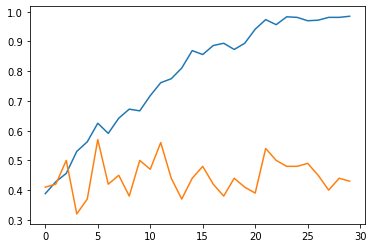

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [34]:
model.save('./model/intervention.h5')

In [ ]:
test_predictions = model.predict(train_examples)
test_predictions = np.argmax(test_predictions, axis=-1)

In [ ]:
result_df = intervention.copy()
result_df["Predictions"] = test_predictions
result_df["Predictions"] = result_df["Predictions"].replace([0,1,2],['N','P','Q'])

result_df.to_csv(
    "predictions.csv",
    columns=["Predictions","Blinding of intervention"],
    header=["Predictions","Blinding of intervention"])

In [ ]:
cm = tf.math.confusion_matrix(y_val, test_predictions[:100])
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

In [ ]:
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")